# Analysis

## Set up

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data preparation

In [2]:
# load the data
data_path = 'data/merged_data/merged_data.csv'
data = pd.read_csv(data_path, header=0)

print(data.columns.tolist())
print(data.shape)

['Country / Territory', 'ISO3', 'Region', 'CPI Score 2023', 'Rank 2023', 'CPI Score 2022', 'Rank 2022', 'CPI Score 2021', 'Rank 2021', 'CPI Score 2020', 'Rank 2020', 'CPI Score 2019', 'Rank 2019', 'CPI Score 2018', 'Rank 2018', 'CPI Score 2017', 'Rank 2017', 'CPI Score 2016', 'CPI Score 2015', 'CPI Score 2014', 'CPI Score 2013', 'CPI Score 2012', 'Country Name', 'Country Code', 'Series Name', 'Series Code', '2022 [YR2022]', '2021 [YR2021]', '2020 [YR2020]', '2019 [YR2019]', '2018 [YR2018]', '2017 [YR2017]', '2016 [YR2016]', '2015 [YR2015]', '2014 [YR2014]', '2013 [YR2013]', '2012 [YR2012]']
(5724, 37)


In [3]:
# subset the data to only include the indicators containing ': Estimate'
data = data[data['Series Name'].str.contains(': Estimate')]
print(data.shape)

indicators = data['Series Name'].unique()
print(indicators)

(954, 37)
['Control of Corruption: Estimate' 'Government Effectiveness: Estimate'
 'Political Stability and Absence of Violence/Terrorism: Estimate'
 'Regulatory Quality: Estimate' 'Rule of Law: Estimate'
 'Voice and Accountability: Estimate']


In [4]:
# subset to the 20% most corrupt countries according to the Corruption Perception Index ranking in 2023
num_countries = int(0.2 * len(data['Country / Territory'].unique()))

In [5]:
subset = data[['Country Name', 'Rank 2023']].drop_duplicates().sort_values(by='Rank 2023', ascending=False).head(num_countries)
corrupt_countries = subset['Country Name'].tolist()

data = data[data['Country / Territory'].isin(corrupt_countries)]
data.head()

,Country / Territory,ISO3,Region,CPI Score 2023,Rank 2023,CPI Score 2022,Rank 2022,CPI Score 2021,Rank 2021,CPI Score 2020,...,2021 [YR2021],2020 [YR2020],2019 [YR2019],2018 [YR2018],2017 [YR2017],2016 [YR2016],2015 [YR2015],2014 [YR2014],2013 [YR2013],2012 [YR2012]
0,Afghanistan,AFG,AP,20.0,162.0,24.0,150.0,16.0,174.0,19.0,...,-1.152327,-1.493700,-1.419499,-1.502881,-1.531910,-1.540353,-1.354240,-1.364743,-1.445908,-1.430373
6,Afghanistan,AFG,AP,20.0,162.0,24.0,150.0,16.0,174.0,19.0,...,-1.669562,-1.609509,-1.518614,-1.501345,-1.388972,-1.290253,-1.396184,-1.359305,-1.399491,-1.375535
12,Afghanistan,AFG,AP,20.0,162.0,24.0,150.0,16.0,174.0,19.0,...,-2.518530,-2.702632,-2.652407,-2.753262,-2.794974,-2.662156,-2.562625,-2.411068,-2.519349,-2.418561
18,Afghanistan,AFG,AP,20.0,162.0,24.0,150.0,16.0,174.0,19.0,...,-1.311682,-1.389163,-1.113778,-1.138204,-1.369763,-1.339695,-1.018826,-1.124134,-1.193090,-1.192580
24,Afghanistan,AFG,AP,20.0,162.0,24.0,150.0,16.0,174.0,19.0,...,-1.876357,-1.831374,-1.741319,-1.688587,-1.583737,-1.520714,-1.515203,-1.437045,-1.609112,-1.651893


In [6]:
def normalize_column(column):
    """Normalizes a column by subtracting the mean and dividing by the standard deviation."""
    mean = column.mean()
    std = column.std()
    return (column - mean) / std

In [7]:
cpi_score_cols = data.columns[data.columns.str.contains('CPI Score')]
data[cpi_score_cols].describe()

# apply normalization to each CPI column
for col in cpi_score_cols:
    data[col] = normalize_column(data[col])

## Model construction

In [8]:
# define the players (countries)
players = data['Country / Territory'].unique().tolist()

# define strategies: Corrupt (C) and Non-Corrupt (NC)
strategies = ['C', 'NC']

# define payoffs
# for PoC, we define some hypothetical payoffs. These should ideally be derived from data.
#          Payoff matrix:
#          --------------------------------
#               |    C       | NC       |
#          --------------------------------
#           C   | (b-c, b-c) | (b, 0)   |
#           NC  | (0, b)     | (d, d)   |

b = 10  # benefit from corrupt strategy
c = 5   # cost of corrupt strategy
d = 8   # benefit from non-corrupt strategy

payoff_matrix = {
    ('C', 'C'): (b-c, b-c),
    ('C', 'NC'): (b, 0),
    ('NC', 'C'): (0, b),
    ('NC', 'NC'): (d, d)
}

## Policy simulation

In [9]:
# define policy interventions and their impact on the payoff matrix
policy_interventions = {
    'Increase Penalties': {'c': 10},                # increase penalties for corruption
    'Improve Government Services': {'d': 12},       # improve government services
    'Strengthen Political Stability': {'b': 8},     # reduce the benefit of corruption
    'Enhance Regulatory Framework': {'d': 14},      # enhance regulatory quality
    'Enforce Rule of Law': {'c': 12},               # enforce rule of law
    'Promote Democratic Participation': {'d': 16}   # promote democratic participation
}

In [10]:
def simulate_policy(policy, num_iterations=100):
    """Simulate the evolution of strategies over time given a policy intervention."""
    results = {}

    # update the payoff matrix based on the policy intervention parameters 
    # use default values if parameters are not provided in the policy
    b_new = policy.get('b', b)
    c_new = policy.get('c', c)
    d_new = policy.get('d', d)
    
    new_payoff_matrix = {
        ('C', 'C'): (b_new-c_new, b_new-c_new),
        ('C', 'NC'): (b_new, 0),
        ('NC', 'C'): (0, b_new),
        ('NC', 'NC'): (d_new, d_new)
    }
    
    for country in players:
        # random initial strategy distribution
        strategy_distribution = {'C': np.random.uniform(0, 1), 'NC': np.random.uniform(0, 1)}
        total_initial = strategy_distribution['C'] + strategy_distribution['NC']
        strategy_distribution = {k: v/total_initial for k, v in strategy_distribution.items()}        

        # simulate the evolution of strategies over time
        for _ in range(num_iterations):
            next_distribution = {'C': 0, 'NC': 0}
            for strategy in strategies:
                for opponent_strategy in strategies:
                    payoff = new_payoff_matrix[(strategy, opponent_strategy)]
                    next_distribution[strategy] += strategy_distribution[opponent_strategy] * payoff[strategy == 'NC']
            total = sum(next_distribution.values())
            if total == 0:
                next_distribution = {'C': 0.5, 'NC': 0.5}
            else:
                next_distribution = {k: v/total for k, v in next_distribution.items()}
            strategy_distribution = next_distribution
        results[country] = strategy_distribution
    
    return results

In [11]:
# define path for analysis results
results_path = Path('results')
results_path.mkdir(parents=True, exist_ok=True)

In [12]:
# apply each policy and store the results
simulation_results = {}
for policy_name, policy_params in policy_interventions.items():
    simulation_results[policy_name] = simulate_policy(policy_params)

# save the simulation results to a JSON file
simulation_results_path = f'{results_path}/simulation_results.json'
with open(simulation_results_path, 'w') as f:
    json.dump(simulation_results, f, indent=4)

## Validate results

In [13]:
def normalize_simulated_cpi(simulated_cpi, real_cpi_mean, real_cpi_std):
    """Normalize the simulated CPI scores based on the real-world data."""
    return (simulated_cpi - real_cpi_mean) / real_cpi_std

In [14]:
def validate_results(simulation_results, val_scores):
    """Validate the simulation results against real-world data."""
    validation_results = {}

    # compute the mean and standard deviation of the real CPI scores
    real_cpi_mean = val_scores['CPI Score 2023'].mean()
    real_cpi_std = val_scores['CPI Score 2023'].std()

    for policy_name, results in simulation_results.items():
        correlation = {}
        for country, distribution in results.items():
            if country in val_scores.index:
                real_cpi = val_scores.loc[country, 'CPI Score 2023']
                simulated_cpi = distribution['NC']  # assuming NC strategy correlates with higher CPI scores
                normalized_simulated_cpi = normalize_simulated_cpi(simulated_cpi, real_cpi_mean, real_cpi_std)
                correlation[country] = (real_cpi, normalized_simulated_cpi)
        
        validation_results[policy_name] = correlation
    return validation_results

In [15]:
# extract real-world data (CPI scores) for validation
val_scores = data[['Country / Territory', 'CPI Score 2023']].drop_duplicates().set_index('Country / Territory')
validation_results = validate_results(simulation_results, val_scores=val_scores)

# calculate statistical measures (e.g., correlation coefficient) for validation
print(f'Correlation coefficient for different policy interventions:')
for policy_name, correlations in validation_results.items():
    real_cpis, normalized_simulated_cpis = zip(*correlations.values())
    correlation_coefficient = np.corrcoef(real_cpis, normalized_simulated_cpis)[0, 1]
    print(f'  {policy_name}: {correlation_coefficient}')

Correlation coefficient for different policy interventions:
  Increase Penalties: -2.154618548609084e-17
  Improve Government Services: 0.2503006668135953
  Strengthen Political Stability: -2.154618548609084e-17
  Enhance Regulatory Framework: 0.029610469939861026
  Enforce Rule of Law: -2.154618548609084e-17
  Promote Democratic Participation: -0.05036437488720203


## Visualization

In [16]:
def plot_policy_impact(simulation_results, original_data):
    for policy_name, simulated_data in simulation_results.items():
        countries = list(simulated_data.keys())
        nc_strategies = [simulated_data[country]['NC'] for country in countries]
        real_cpis = [original_data.loc[country, 'CPI Score 2023'] for country in countries if country in original_data.index]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(real_cpis, nc_strategies)
        plt.xlabel('Real CPI Scores')
        plt.ylabel('Simulated NC Strategy Proportion')
        plt.title(f'Simulation Results for Policy: {policy_name}')
        plt.show()

In [17]:
def plot_policy_impact(simulation_results, original_data, real_cpi_mean, real_cpi_std):
    for policy_name, simulated_data in simulation_results.items():
        countries = list(simulated_data.keys())
        nc_strategies = [simulated_data[country]['NC'] for country in countries]
        real_cpis = [original_data.loc[country, 'CPI Score 2023'] for country in countries if country in original_data.index]
        
        normalized_nc_strategies = [(nc - real_cpi_mean) / real_cpi_std for nc in nc_strategies]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(real_cpis, normalized_nc_strategies)
        plt.xlabel('Real CPI Scores')
        plt.ylabel('Normalized Simulated NC Strategy Proportion')
        plt.title(f'Simulation Results for Policy: {policy_name}')
        plt.show()

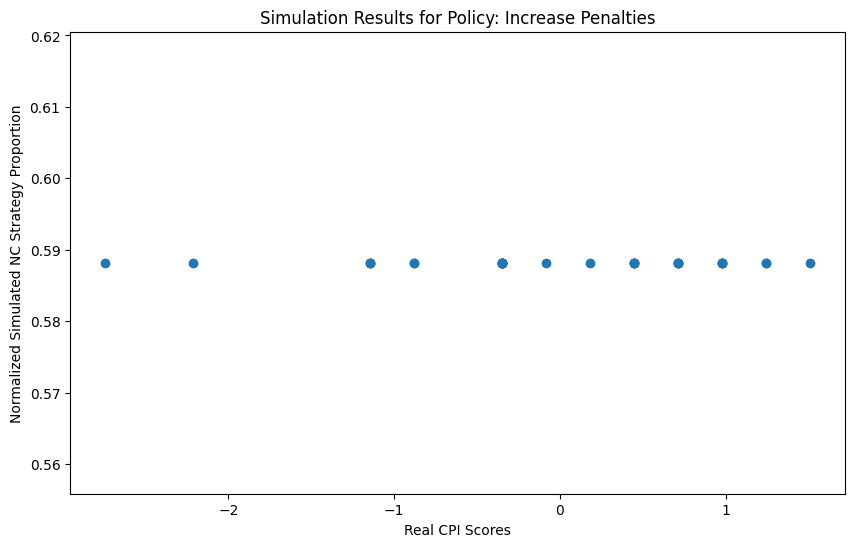

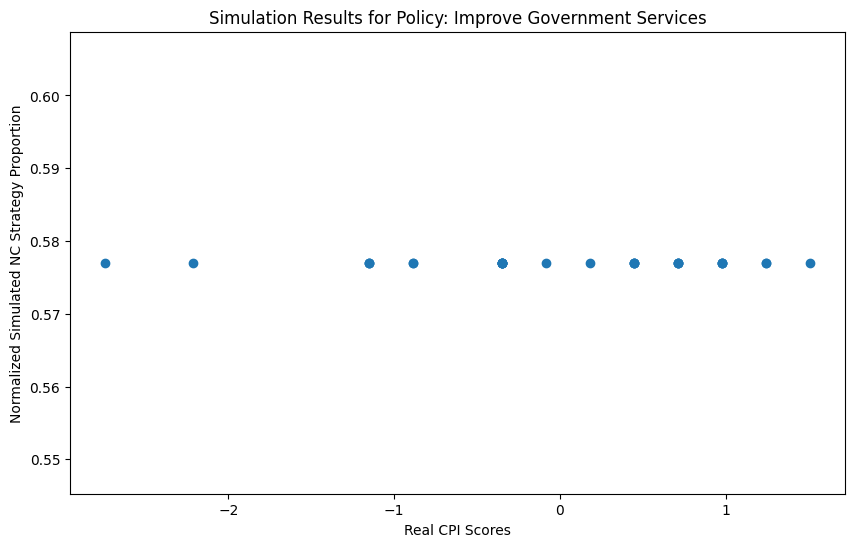

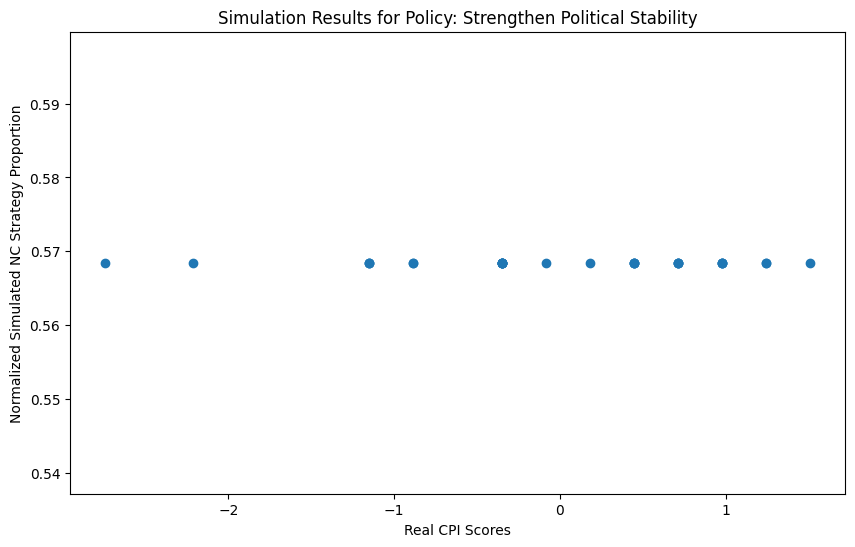

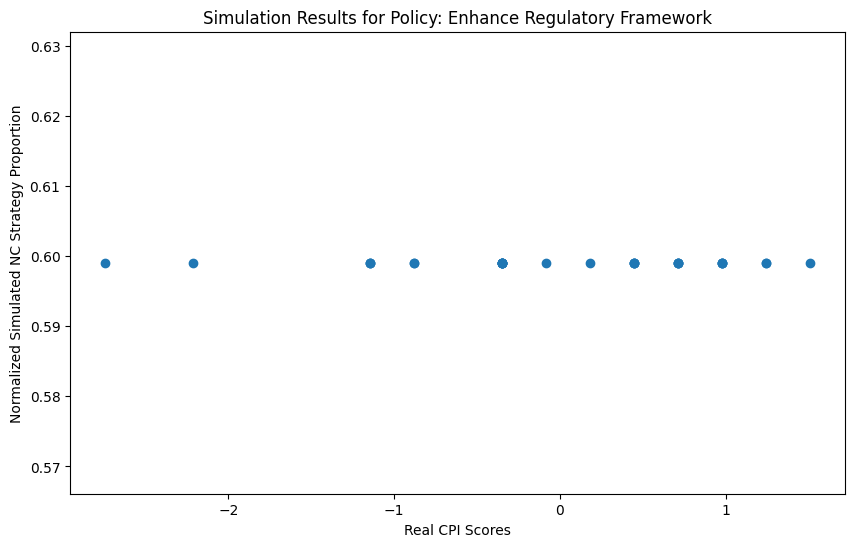

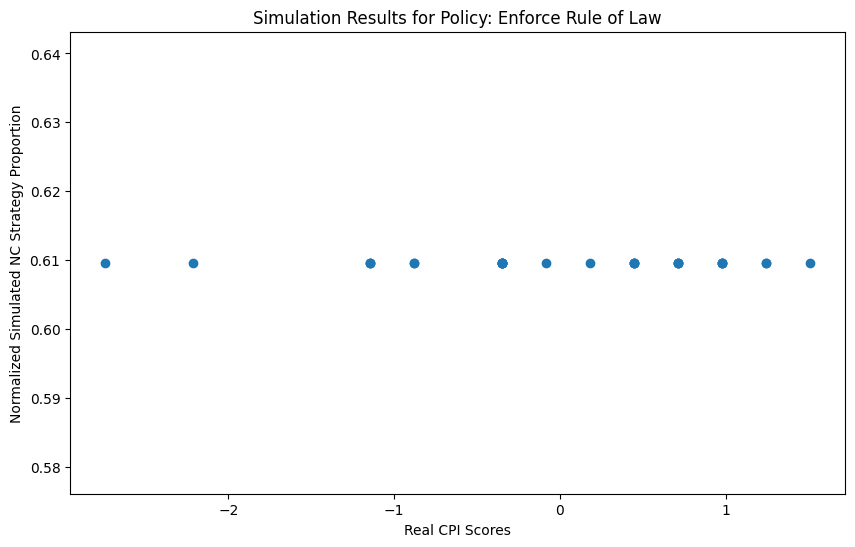

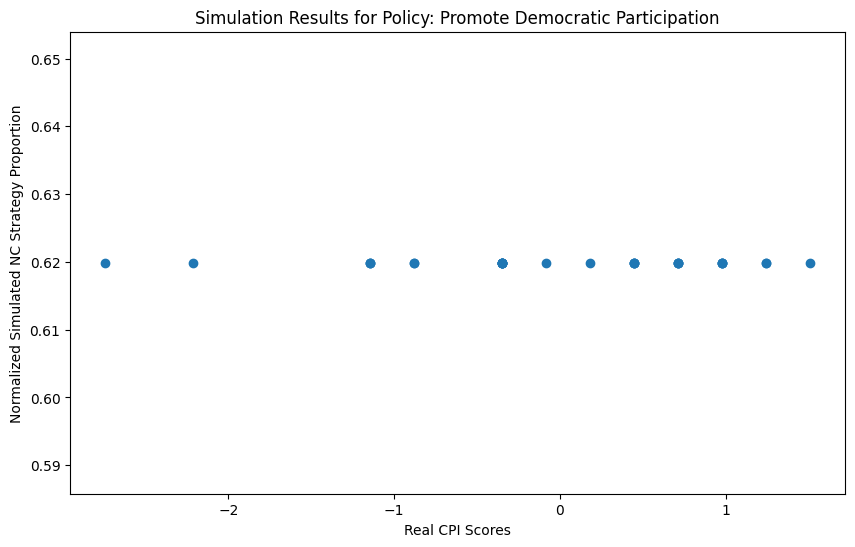

In [18]:
real_cpi_mean = val_scores['CPI Score 2023'].mean()
real_cpi_std = val_scores['CPI Score 2023'].std()

plot_policy_impact(simulation_results, val_scores, real_cpi_mean, real_cpi_std)